In [1]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Các model scikit learn cho bài toán phân loại
from sklearn.svm import SVC # Support vector machine
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import json
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

import os, sys
sys.path.append(os.path.abspath(".."))

from utils.training_storage_helper import save_params, save_model
from utils.progress_wrapper import ProgressWrapper

seed = 42
np.random.seed(seed)

### Setup params

In [2]:
hyper_parameters_path = "../hyper_parameters"
model_path = "../best_models"

# 1. Prepare data

In [3]:
train_df = pd.read_csv("../../data/key_points_zip.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               438 non-null    object 
 1   nose_x              438 non-null    float64
 2   nose_y              438 non-null    float64
 3   nose_z              438 non-null    float64
 4   left_shoulder_x     438 non-null    float64
 5   left_shoulder_y     438 non-null    float64
 6   left_shoulder_z     438 non-null    float64
 7   right_shoulder_x    438 non-null    float64
 8   right_shoulder_y    438 non-null    float64
 9   right_shoulder_z    438 non-null    float64
 10  left_elbow_x        438 non-null    float64
 11  left_elbow_y        438 non-null    float64
 12  left_elbow_z        438 non-null    float64
 13  right_elbow_x       438 non-null    float64
 14  right_elbow_y       438 non-null    float64
 15  right_elbow_z       438 non-null    float64
 16  left_pin

In [5]:
train_df.columns

Index(['label', 'nose_x', 'nose_y', 'nose_z', 'left_shoulder_x',
       'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y',
       'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z',
       'left_pinky_x', 'left_pinky_y', 'left_pinky_z', 'right_pinky_x',
       'right_pinky_y', 'right_pinky_z', 'left_index_x', 'left_index_y',
       'left_index_z', 'right_index_x', 'right_index_y', 'right_index_z',
       'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'right_hip_y',
       'right_hip_z', 'left_knee_x', 'left_knee_y', 'left_knee_z',
       'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_foot_index_x',
       'left_foot_index_y', 'left_foot_index_z', 'right_foot_index_x',
       'right_foot_index_y', 'right_foot_index_z'],
      dtype='object')

In [6]:
train_df.head()

,label,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,...,left_knee_z,right_knee_x,right_knee_y,right_knee_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,1_lie_on,0.043735,-0.438350,-0.262433,0.187232,-0.277906,-0.003749,-0.187232,-0.222094,-0.029898,...,-0.368347,-0.340792,0.461691,-0.327776,-0.094777,0.961264,-0.166788,-0.178679,1.027750,-0.190334
1,1_lie_on,-0.012077,-0.438393,-0.340744,0.162144,-0.256732,-0.080526,-0.162144,-0.243268,-0.076776,...,-0.368634,-0.173237,0.496333,-0.323120,0.051305,0.810328,-0.046716,-0.160051,0.880444,-0.097076
2,1_lie_on,0.012135,-0.373490,-0.618891,0.193283,-0.238847,-0.239922,-0.193283,-0.261153,-0.303496,...,-0.121838,-0.062481,0.620328,-0.212551,0.231620,0.713266,0.287587,0.089882,1.046537,0.005253
3,1_lie_on,0.094005,-0.439339,-0.151025,0.200254,-0.270825,0.059334,-0.200254,-0.229175,0.036278,...,-0.424671,-0.167933,0.402698,-0.369049,-0.054249,0.855183,-0.285776,-0.090941,0.831457,-0.380920
4,1_lie_on,-0.029846,-0.490374,-0.204487,0.188421,-0.232547,0.018425,-0.188421,-0.267453,0.057951,...,-0.381305,-0.311834,0.362723,-0.452312,0.273508,0.729336,-0.119508,0.002807,0.799412,-0.203064


<Axes: xlabel='label', ylabel='count'>

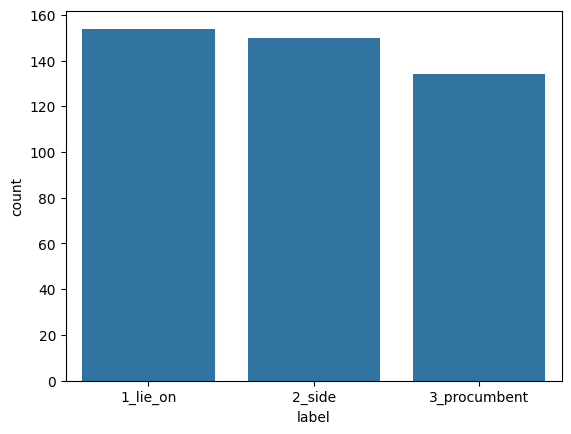

In [7]:
sns.countplot(x="label", data=train_df)

# 2. Pre-training

In [8]:
# Chuyển dữ liệu của label về dạng số
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])

In [9]:
# Extract features
X_train = train_df.drop(columns="label")
y_train = train_df["label"]

In [10]:
X_train.head()

,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,left_elbow_x,...,left_knee_z,right_knee_x,right_knee_y,right_knee_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,0.043735,-0.438350,-0.262433,0.187232,-0.277906,-0.003749,-0.187232,-0.222094,-0.029898,0.322146,...,-0.368347,-0.340792,0.461691,-0.327776,-0.094777,0.961264,-0.166788,-0.178679,1.027750,-0.190334
1,-0.012077,-0.438393,-0.340744,0.162144,-0.256732,-0.080526,-0.162144,-0.243268,-0.076776,0.317513,...,-0.368634,-0.173237,0.496333,-0.323120,0.051305,0.810328,-0.046716,-0.160051,0.880444,-0.097076
2,0.012135,-0.373490,-0.618891,0.193283,-0.238847,-0.239922,-0.193283,-0.261153,-0.303496,0.333375,...,-0.121838,-0.062481,0.620328,-0.212551,0.231620,0.713266,0.287587,0.089882,1.046537,0.005253
3,0.094005,-0.439339,-0.151025,0.200254,-0.270825,0.059334,-0.200254,-0.229175,0.036278,0.394793,...,-0.424671,-0.167933,0.402698,-0.369049,-0.054249,0.855183,-0.285776,-0.090941,0.831457,-0.380920
4,-0.029846,-0.490374,-0.204487,0.188421,-0.232547,0.018425,-0.188421,-0.267453,0.057951,0.403694,...,-0.381305,-0.311834,0.362723,-0.452312,0.273508,0.729336,-0.119508,0.002807,0.799412,-0.203064


In [11]:
y_train

0      0
1      0
2      0
3      0
4      0
      ..
433    2
434    2
435    2
436    2
437    2
Name: label, Length: 438, dtype: int32

In [12]:
# Chuẩn hoá dữ liệu trên tập huấn luyện bằng z-scores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [13]:
# X lúc này là một DataFrame mới với các cột mới được đánh số từ 0 đến n-1, trong đó n là số lượng cột trong dữ liệu ban đầu
X_train

array([[ 0.52617274, -0.39964606, -0.2264958 , ..., -0.53192388,
         1.81750221, -0.6673203 ],
       [-0.05341464, -0.40072812, -0.57035406, ..., -0.47031214,
         1.07477765, -0.46040318],
       [ 0.19802186,  1.243413  , -1.79168718, ...,  0.35636668,
         1.91222354, -0.23335835],
       ...,
       [ 0.19029373, -1.23207109, -0.25500308, ...,  0.19988515,
        -1.14650511,  1.22195221],
       [ 0.14170732,  0.19499449,  1.68849408, ...,  0.17020899,
        -0.26409674, -0.08077349],
       [-0.13412318, -0.65454917,  2.87906998, ...,  1.68701331,
         1.4542938 , -0.67505219]])

# 3. Training

In [14]:
k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

In [15]:
def evaluate_model(name, model, results):
    # Đánh giá Model
    accuracy = cross_val_score(
        model, X_train, y_train, cv=k_fold, scoring="accuracy", n_jobs=-1, verbose=1
    ).mean()

    f1_score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring="f1_macro").mean()
    results.append((name, accuracy, f1_score))

In [16]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    ("SVC", SVC(probability=True, random_state=seed)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("RF", RandomForestClassifier(random_state=seed)),
    ("XGB", XGBClassifier(random_state=seed)),
]

models = {}
results_before_tunning = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model
    evaluate_model(name, model, results_before_tunning)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [17]:
def print_results(results):
    results.sort(key=lambda el: el[2], reverse=True)

    return pd.DataFrame(
        results,
        columns=[
            "Model",
            "Accuracy score",
            "F1 score",
        ],
    )

print_results(results_before_tunning)

,Model,Accuracy score,F1 score
0,RF,0.899478,0.896553
1,SVC,0.890413,0.886571
2,XGB,0.879049,0.875940
3,KNN,0.872100,0.870017
4,LR,0.842529,0.836805
5,DTC,0.828814,0.825014


<Axes: xlabel='F1 score', ylabel='Model'>

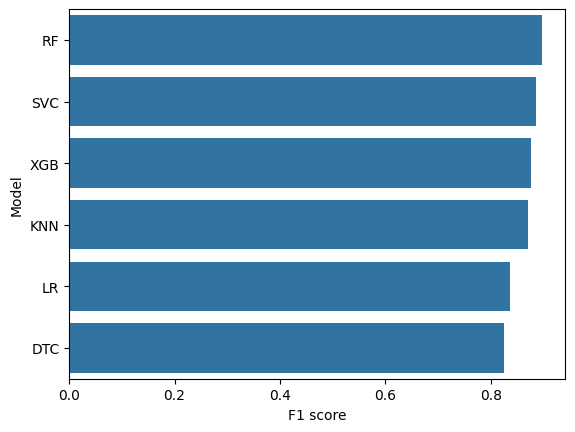

In [18]:
sns.barplot(x="F1 score", y="Model", data=print_results(results_before_tunning))

# 4. Evaluate

In [19]:
y_pred = models['RF'].predict(X_train)
cm_full_train = confusion_matrix(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
cm_full_train, accuracy

(array([[153,   1,   0],
        [  1, 149,   0],
        [  0,   0, 134]], dtype=int64),
 0.9954337899543378)

In [20]:
svc_best_model = RandomForestClassifier(random_state=seed)

svc_best_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
accuracy = cross_val_score(svc_best_model, X_train, y_train, cv=k_fold, scoring="accuracy").mean()
y_pred = cross_val_predict(svc_best_model, X_train, y_train, cv=k_fold)
cm_cross_val = confusion_matrix(y_train, y_pred)
accuracy, cm_cross_val

(0.8994775339602926,
 array([[144,   9,   1],
        [  8, 140,   2],
        [ 13,  11, 110]], dtype=int64))

<Axes: >

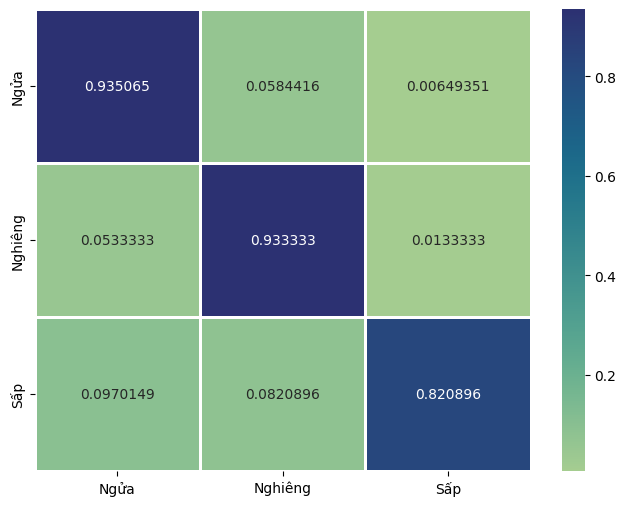

In [22]:
label_counts = np.sum(cm_cross_val, axis=1)
cm_cross_val = cm_cross_val / label_counts[:, None]
confusion_matrix_df = pd.DataFrame(cm_cross_val, index=["Ngửa", "Nghiêng", "Sấp"], columns=["Ngửa", "Nghiêng", "Sấp"])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, linewidths=1, annot=True, ax=ax, fmt="g", cmap="crest")

# 5. Find best model

In [23]:
results_after_tuning = []

In [24]:
random_forest = models["RF"]

# Định nghĩa phạm vi của các siêu tham số cần tối ưu
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Tạo RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = random_forest, param_distributions = param_grid,
                                n_iter = 100, cv = k_fold, verbose=3, random_state=seed, n_jobs = -1)

# Tiến hành tìm kiếm siêu tham số
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=3)

In [25]:
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 30,
 'bootstrap': False}

In [26]:
save_params(random_search.best_params_, f"./{hyper_parameters_path}/random_forest.json")

In [27]:
with open(f'./{hyper_parameters_path}/random_forest.json', 'r') as f:
    best_params = json.load(f)
    best_params["bootstrap"] = bool(best_params["bootstrap"])

# Khởi tạo một mô hình Random Forest mới với các tham số tối ưu
best_random_forest_model = RandomForestClassifier(**best_params, random_state=seed, verbose=1)
best_random_forest_model.fit(X_train, y_train)

# Huấn luyện mô hình mới với dữ liệu huấn luyện của bạn
result = []
evaluate_model("RF", best_random_forest_model, result)
results_after_tuning.append(result[0])
print_results(result)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s

,Model,Accuracy score,F1 score
0,RF,0.906348,0.903644


In [28]:
accuracy_rf_best = cross_val_score(best_random_forest_model, X_train, y_train, cv=k_fold, scoring="accuracy").mean()
y_pred_rf_best = cross_val_predict(best_random_forest_model, X_train, y_train, cv=k_fold)
cm_cross_val_rf_best = confusion_matrix(y_train, y_pred_rf_best)
accuracy_rf_best, cm_cross_val_rf_best

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

(0.9063479623824453,
 array([[145,   8,   1],
        [  7, 140,   3],
        [ 13,   9, 112]], dtype=int64))

<Axes: >

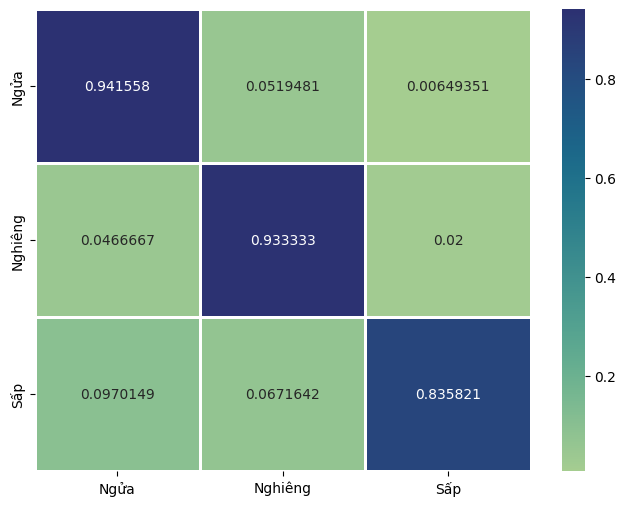

In [29]:
label_counts = np.sum(cm_cross_val_rf_best, axis=1)
cm_cross_val = cm_cross_val_rf_best / label_counts[:, None]
confusion_matrix_df = pd.DataFrame(cm_cross_val, index=["Ngửa", "Nghiêng", "Sấp"], columns=["Ngửa", "Nghiêng", "Sấp"])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, linewidths=1, annot=True, ax=ax, fmt="g", cmap="crest")

In [30]:
save_model(scaler, f"{model_path}/input_scaler.pkl")
save_model(best_random_forest_model, f"{model_path}/random_forest.pkl")

In [31]:
from sklearn.model_selection import GridSearchCV

svc_model = models["SVC"]

param_grid = {
    "decision_function_shape": ["ovo", "ovr", "ovo", "ovr"],
    "gamma": ["scale", "auto", "scale", "auto"],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
}

# Tạo GridSearchCV instance
svc_best_model = GridSearchCV(svc_model, param_grid, cv=5, verbose=3, n_jobs=-1)

# Tiến hành tinh chỉnh siêu tham số trên mô hình đã huấn luyện
svc_best_model.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất được tìm thấy
print("Best Parameters:", svc_best_model.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}


In [33]:
json.dump(svc_best_model.best_params_, open(f"{hyper_parameters_path}/SVC.json", "w"))

In [34]:
best_params = json.load(open(f"{hyper_parameters_path}/SVC.json", "r"))
svc_best_model = SVC(**best_params, random_state=seed)
svc_best_model.fit(X_train, y_train)

SVC(decision_function_shape='ovo', random_state=42)

In [35]:
result = []
evaluate_model("SVC", svc_best_model, result)
print_results(result)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


,Model,Accuracy score,F1 score
0,SVC,0.890413,0.886571


In [36]:
save_model(svc_best_model, f"{model_path}/svc.pkl")